# Import Library

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Loading

## Ambil Data Dari Kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"blehhhh","key":"49e009f7f90a425c9d00a93e4a93f860"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

https://www.kaggle.com/datasets/trolukovich/food11-image-dataset?select=training

In [6]:
!kaggle datasets download -d trolukovich/food11-image-dataset
!unzip food11-image-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: training/Soup/223.jpg   
  inflating: training/Soup/224.jpg   
  inflating: training/Soup/225.jpg   
  inflating: training/Soup/226.jpg   
  inflating: training/Soup/227.jpg   
  inflating: training/Soup/228.jpg   
  inflating: training/Soup/229.jpg   
  inflating: training/Soup/23.jpg    
  inflating: training/Soup/230.jpg   
  inflating: training/Soup/231.jpg   
  inflating: training/Soup/232.jpg   
  inflating: training/Soup/233.jpg   
  inflating: training/Soup/234.jpg   
  inflating: training/Soup/235.jpg   
  inflating: training/Soup/236.jpg   
  inflating: training/Soup/237.jpg   
  inflating: training/Soup/238.jpg   
  inflating: training/Soup/239.jpg   
  inflating: training/Soup/24.jpg    
  inflating: training/Soup/240.jpg   
  inflating: training/Soup/241.jpg   
  inflating: training/Soup/242.jpg   
  inflating: training/Soup/243.jpg   
  inflating: training/Soup/244.jpg   
  inflating: training/Soup/24

## Data Preparation

In [7]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

In [8]:
training_dir = 'food11/training'
validation_dir = 'food11/validation'
combined_dir = 'food11/combined'

In [16]:
os.makedirs(combined_dir, exist_ok=True)
os.makedirs(training_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [10]:
!mkdir -p food11/combined/
!cp -r training/* food11/combined/

In [11]:
!mkdir -p food11/combined/
!cp -r validation/* food11/combined/

In [18]:
!ls food11

combined  training  validation


In [19]:
# Salin file dan folder dari training
for category in os.listdir(training_dir):
    category_dir = os.path.join(training_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari validation
for category in os.listdir(validation_dir):
    category_dir = os.path.join(validation_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

print("Data berhasil disalin dari training dan validation ke combined")

Data berhasil disalin dari training dan validation ke combined


## Dataset Checking

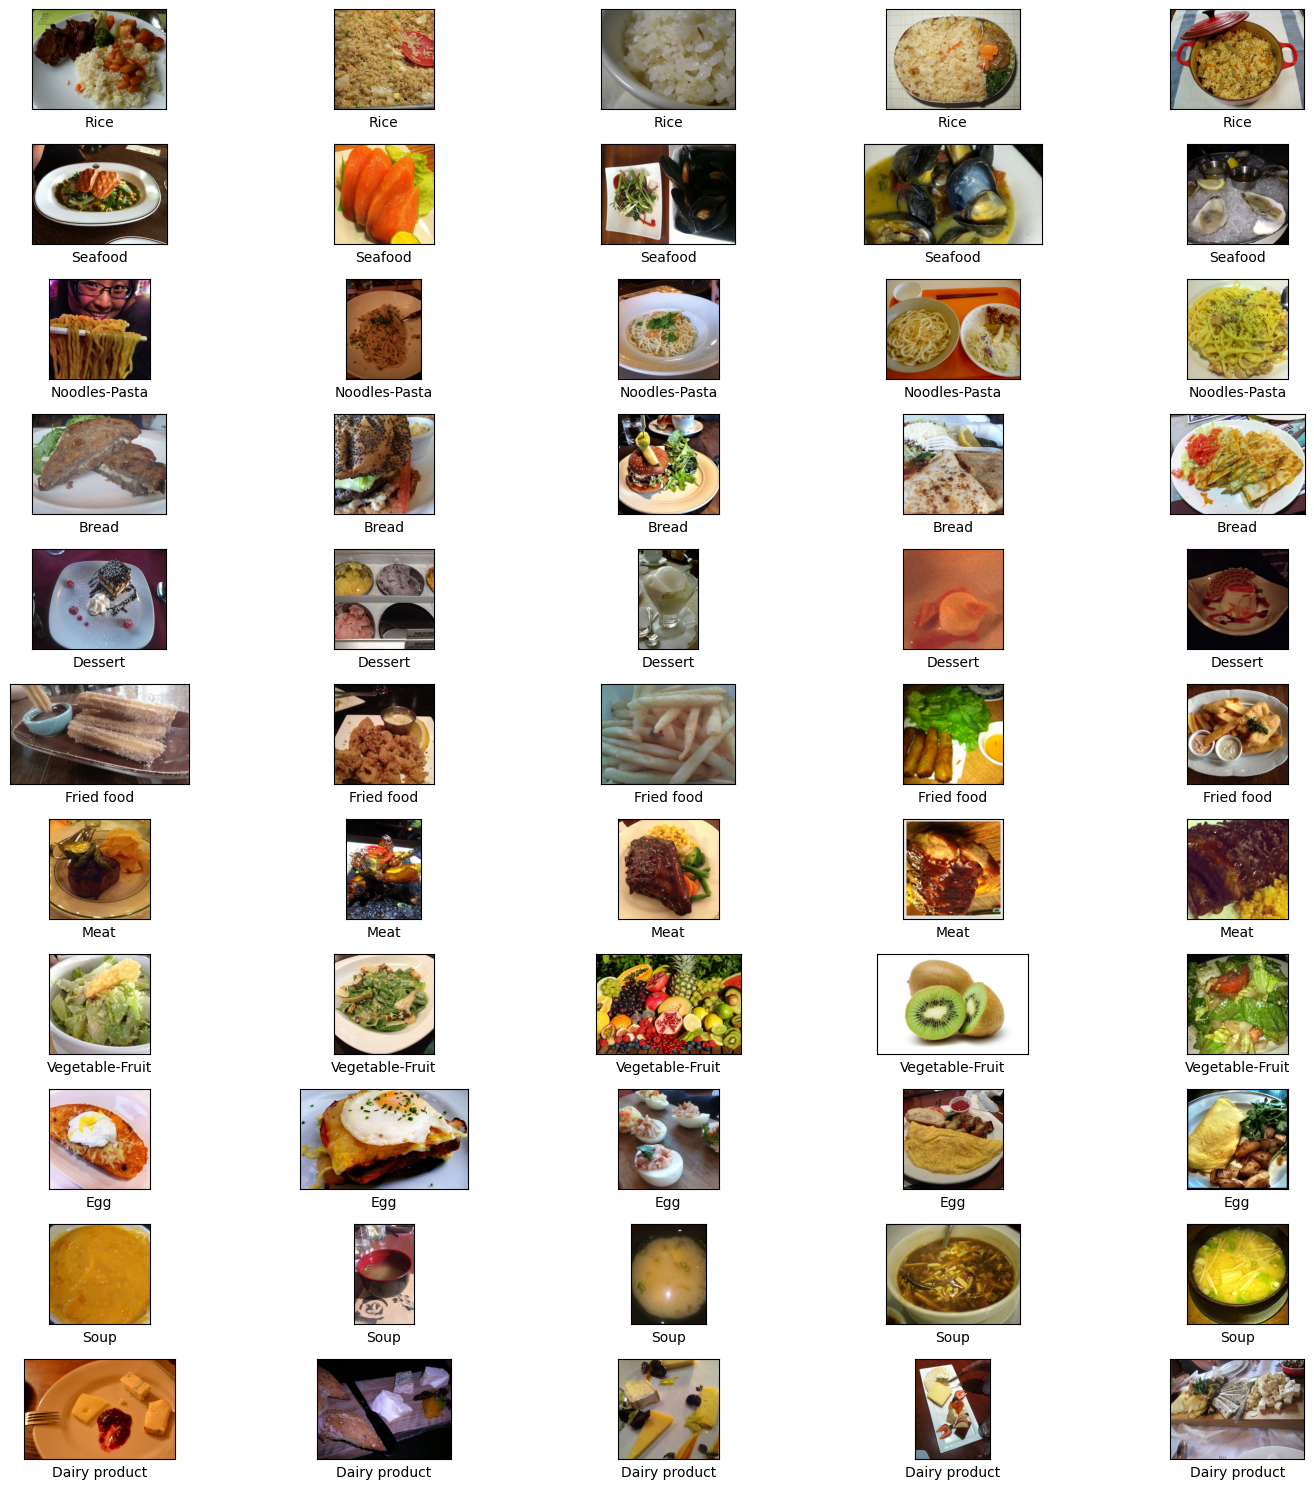

In [20]:
import matplotlib.pyplot as plt

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
food_image = {}

# Tentukan path sumber train
path = 'food11/combined/'
for category in os.listdir(path):
    food_image[category] = os.listdir(os.path.join(path, category))

# Menampilkan secara acak 5 gambar dari setiap kelas
fig, axs = plt.subplots(len(food_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(food_image.keys()):
    images = np.random.choice(food_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Konversi menjadi RGB
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

## Plot Distribusi

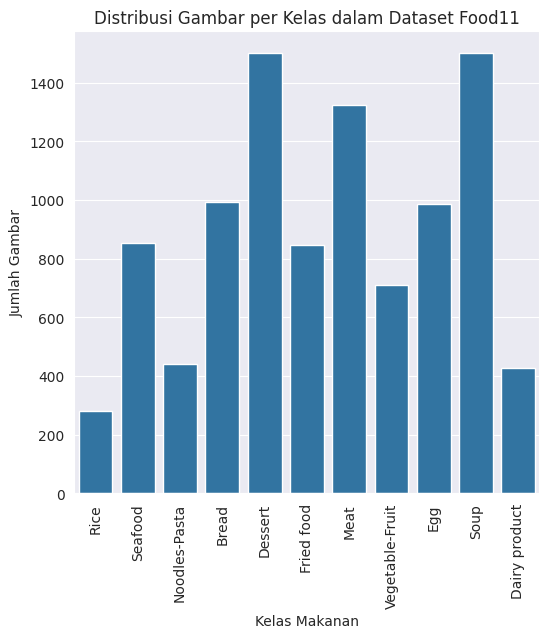

In [21]:
import seaborn as sns

food_path = "food11/combined/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

for category in os.listdir(food_path):
    category_path = os.path.join(food_path, category)
    if os.path.isdir(category_path):
        for name in os.listdir(category_path):
            full_path.append(os.path.join(category_path, name))
            labels.append(category)
            file_name.append(name)

# Membuat dataframe
distribution_food = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot distribusi gambar di setiap kelas
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_food)

# Menambahkan label dan judul
plt.title('Distribusi Gambar per Kelas dalam Dataset Food11')
plt.xlabel('Kelas Makanan')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=90)
plt.show()

# Data Augmentation

In [22]:
# Rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Mengubah gambar ke format RGB
    img = cv2.resize(img, (224, 224))  # Menyesuaikan ukuran gambar
    sudut = random.randint(0, 180)  # Menghasilkan sudut acak
    # Melakukan rotasi berlawanan arah jarum jam
    rotated_img = rotate(img, sudut)
    return rotated_img

# Rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    sudut = random.randint(0, 180)
    # Melakukan rotasi searah jarum jam
    rotated_img = rotate(img, -sudut)
    return rotated_img

# Membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    # Membalik gambar secara vertikal
    flipped_img = np.flipud(img)
    return flipped_img

# Peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    # Menambahkan kecerahan dengan penyesuaian gamma
    bright_img = adjust_gamma(img, gamma=0.5, gain=1)
    return bright_img

# Efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    # Menambahkan efek blur Gaussian
    blurred_img = cv2.GaussianBlur(img, (9, 9), 0)
    return blurred_img

# Pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    # Melakukan transformasi shearing (pergeseran) acak
    transform = AffineTransform(shear=0.2)
    shear_img = warp(img, transform, mode="wrap")
    return shear_img

# Pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    # Melakukan transformasi pergeseran (translation)
    transform = AffineTransform(translation=(0, 40))
    warped_img = warp(img, transform, mode="wrap")
    return warped_img

In [23]:
import os
import random
from skimage import io
from skimage import img_as_ubyte
import cv2

transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "food11/combined"  # Path untuk gambar asli
augmented_path = "food11/combined_augmented"  # Path untuk gambar yang sudah diaugmentasi
images = []

# Menelusuri seluruh subfolder dan file gambar di dalam folder combined
for root, dirs, files in os.walk(images_path):
    for im in files:
        img_path = os.path.join(root, im)

        if im.lower().endswith(('.jpg')):
            images.append(img_path)

print(f"Found {len(images)} images.")

images_to_generate = 2000
i = 1

# Melakukan augmentasi untuk menghasilkan gambar
while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image = None
        n = 0
        transformation_count = random.randint(1, len(transformations))

        while n <= transformation_count:
            key = random.choice(list(transformations))
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = f"{augmented_path}/augmented_image_{i}.jpg"
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, transformed_image)
        i = i + 1
    except ValueError as e:
        print(f'Could not read the {image}: {e}, hence skipping it.')


Found 9866 images.


In [119]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

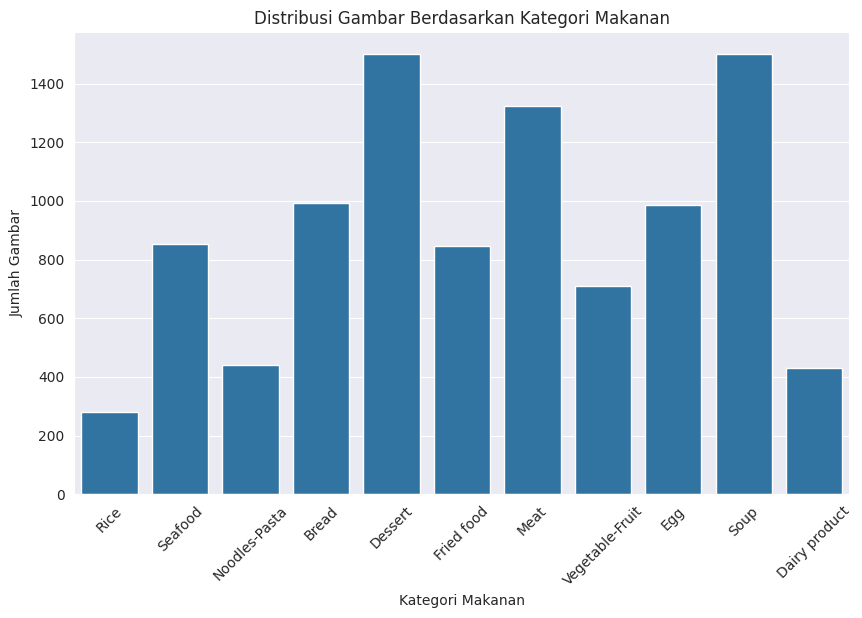

In [66]:
# Definisikan path sumber
food_path = "food11/combined/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for folder in os.listdir(food_path):
    folder_path = os.path.join(food_path, folder)
    if os.path.isdir(folder_path):
        for name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, name)
            if name.lower().endswith(('.jpg')):
                full_path.append(file_path)
                labels.append(folder)
                file_name.append(name)

# Membuat dataframe dengan informasi path, file_name, dan label
distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

Label = distribution_train['labels']
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x=Label)
plt.title('Distribusi Gambar Berdasarkan Kategori Makanan')
plt.xlabel('Kategori Makanan')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.show()

# Data Splitting

In [67]:
mypath= 'food11/combined'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Bread,994
Dairy product,429
Dessert,1500
Egg,986
Fried food,848
Meat,1325
Noodles-Pasta,440
Rice,280
Seafood,855


In [68]:
X = df['path']
y = df['labels']

# Split combined menjadi gabungan antara test dan validation
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=300)  # 20% menjadi gabungan test dan validation

# Split temp menjadi data test dan validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=300)

# Menampilkan jumlah data pada masing-masing set
print(f'Jumlah Training Set: {len(X_train)}')
print(f'Jumlah Testing Set: {len(X_test)}')
print(f'Jumlah Validation Set: {len(X_val)}')

Jumlah Training Set: 7892
Jumlah Testing Set: 987
Jumlah Validation Set: 987


In [69]:
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'validation'})

df_combined = pd.concat([df_tr, df_te], ignore_index=True)
df_combined = pd.concat([df_combined, df_val], ignore_index=True)

In [70]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "food11/combined/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels         
test   Bread               103
       Dairy product        40
       Dessert             151
       Egg                  91
       Fried food           92
       Meat                127
       Noodles-Pasta        49
       Rice                 27
       Seafood              88
       Soup                139
       Vegetable-Fruit      80
train  Bread               795
       Dairy product       344
       Dessert            1207
       Egg                 792
       Fried food          672
       Meat               1061
       Noodles-Pasta       352
       Rice                223
       Seafood             676
       Soup               1201
       Vegetable-Fruit     569
dtype: int64 


                                    path      labels    set
3152     food11/combined/Seafood/567.jpg     Seafood  train
111          food11/combined/Egg/382.jpg         Egg  train
8730       food11/combined/Bread/942.jpg       Bread   test
3845  food11/combined/Fried food/842.j

In [71]:
from tqdm import tqdm

for index, row in tqdm(df_all.iterrows(), total=df_all.shape[0]):
    # Deteksi filepath
    file_path = row['path']

    # Jika file tidak ditemukan, buat path alternatif
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'].split('.')[0])

    # Buat direktori tujuan jika belum ada
    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Tentukan nama file tujuan
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(target_dir, destination_file_name)

    # Salin file dari sumber ke tujuan jika file belum ada
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

100%|██████████| 8879/8879 [00:01<00:00, 4474.43it/s]


In [72]:
import os
import shutil
import random

train_path = "Dataset-Final/train/"
validation_path = "Dataset-Final/validation/"

for class_folder in os.listdir(train_path):
    class_train_dir = os.path.join(train_path, class_folder)
    class_val_dir = os.path.join(validation_path, class_folder)

    os.makedirs(class_val_dir, exist_ok=True)

    files = os.listdir(class_train_dir)
    random.shuffle(files)

    val_count = int(0.2 * len(files))
    val_files = files[:val_count]

    for file in val_files:
        src_file = os.path.join(class_train_dir, file)
        dst_file = os.path.join(class_val_dir, file)
        shutil.move(src_file, dst_file)

# Image Data Generator

In [73]:
# Definisikan direktori untuk training, test, dan validation
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"
VALIDATION_DIR = "Dataset-Final/validation/"

# Daftar untuk masing-masing kategori pada train, test, dan validation
train_folders = os.listdir(TRAIN_DIR)
test_folders = os.listdir(TEST_DIR)
validation_folders = os.listdir(VALIDATION_DIR)

# Menampilkan jumlah gambar untuk setiap kategori di masing-masing set
for folder in train_folders:
    print(f"Total number of {folder} images in training set: ", len(os.listdir(os.path.join(TRAIN_DIR, folder))))

for folder in test_folders:
    print(f"Total number of {folder} images in test set: ", len(os.listdir(os.path.join(TEST_DIR, folder))))

for folder in validation_folders:
    print(f"Total number of {folder} images in validation set: ", len(os.listdir(os.path.join(VALIDATION_DIR, folder))))


Total number of Rice images in training set:  179
Total number of Seafood images in training set:  541
Total number of Noodles-Pasta images in training set:  282
Total number of Bread images in training set:  636
Total number of Dessert images in training set:  966
Total number of Fried food images in training set:  538
Total number of Meat images in training set:  849
Total number of Vegetable-Fruit images in training set:  456
Total number of Egg images in training set:  634
Total number of Soup images in training set:  961
Total number of Dairy product images in training set:  276
Total number of Rice images in test set:  27
Total number of Seafood images in test set:  88
Total number of Noodles-Pasta images in test set:  49
Total number of Bread images in test set:  103
Total number of Dessert images in test set:  151
Total number of Fried food images in test set:  92
Total number of Meat images in test set:  127
Total number of Vegetable-Fruit images in test set:  80
Total number 

In [106]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Direktori untuk train, test, dan validation
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"
VALIDATION_DIR = "Dataset-Final/validation/"

# Train generator (subset training)
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# Validation generator (subset validation)
validation_generator = datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

# Test generator untuk data uji
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='sparse',
    shuffle=False
)

Found 5059 images belonging to 11 classes.
Found 563 images belonging to 11 classes.
Found 987 images belonging to 11 classes.


# Pelatihan Model

In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model_food11 = Sequential()

# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_food11.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model_food11.add(BatchNormalization())
model_food11.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_food11.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_food11.add(BatchNormalization())
model_food11.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_food11.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_food11.add(BatchNormalization())
model_food11.add(MaxPooling2D((2, 2)))

# Flatten layer
model_food11.add(Flatten())
# 1st Dense Layer
model_food11.add(Dense(128, activation='relu'))
# 1st Dropout Layer
model_food11.add(Dropout(0.5))
# 2nd Dense Layer
model_food11.add(Dense(64, activation='relu'))
# 2nd Dropout Layer
model_food11.add(Dropout(0.3))

# Final Dense layer => For output prediction 11 classes (Food11 dataset)
model_food11.add(Dense(11, activation='softmax'))

model_food11.compile(optimizer=tf.keras.optimizers.RMSprop(),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Summary of the Model Architecture
print(model_food11.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 75, 75, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 37, 37, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 37, 37, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,404,107 (5.36 MB)

 Trainable params: 1,403,915 (5.36 MB)

 Non-trainable params: 192 (768.00 B)

None


In [109]:
print("Jumlah batch pada training generator:", train_generator.samples)
print("Jumlah batch pada validation generator:", validation_generator.samples)

Jumlah batch pada training generator: 5059
Jumlah batch pada validation generator: 563


In [110]:
print("Total batches in train_generator:", len(train_generator))

Total batches in train_generator: 159


In [111]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))

In [128]:
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model_food11 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(11, activation='softmax')
])

# Compile
model_food11.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_food11.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)

# Training
history_food11 = model_food11.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3544 - loss: 3.9791

159/159 ━━━━━━━━━━━━━━━━━━━━ 36s 171ms/step - accuracy: 0.3553 - loss: 3.9749 - val_accuracy: 0.7425 - val_loss: 2.3308 - learning_rate: 5.0000e-04
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6738 - loss: 2.2999

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.6739 - loss: 2.2987 - val_accuracy: 0.7709 - val_loss: 1.7908 - learning_rate: 5.0000e-04
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7413 - loss: 1.7183

159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.7413 - loss: 1.7177 - val_accuracy: 0.8028 - val_loss: 1.4798 - learning_rate: 5.0000e-04
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7821 - loss: 1.3827

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.7821 - loss: 1.3825 - val_accuracy: 0.7744 - val_loss: 1.3086 - learning_rate: 5.0000e-04
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7869 - loss: 1.1876

159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.7869 - loss: 1.1874 - val_accuracy: 0.7780 - val_loss: 1.2303 - learning_rate: 5.0000e-04
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8134 - loss: 1.0307

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.8134 - loss: 1.0306 - val_accuracy: 0.7975 - val_loss: 1.0644 - learning_rate: 5.0000e-04
Epoch 7/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8331 - loss: 0.9160

159/159 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.8330 - loss: 0.9160 - val_accuracy: 0.8028 - val_loss: 0.9982 - learning_rate: 5.0000e-04
Epoch 8/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8280 - loss: 0.8491

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.8280 - loss: 0.8491 - val_accuracy: 0.8064 - val_loss: 0.9457 - learning_rate: 5.0000e-04
Epoch 9/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8221 - loss: 0.8134

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.8221 - loss: 0.8134 - val_accuracy: 0.8046 - val_loss: 0.9114 - learning_rate: 5.0000e-04
Epoch 10/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8309 - loss: 0.7554

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8309 - loss: 0.7555 - val_accuracy: 0.8082 - val_loss: 0.8993 - learning_rate: 5.0000e-04
Epoch 11/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8324 - loss: 0.7245

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.8324 - loss: 0.7247 - val_accuracy: 0.8011 - val_loss: 0.8788 - learning_rate: 5.0000e-04
Epoch 12/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.8494 - loss: 0.6982 - val_accuracy: 0.7957 - val_loss: 0.8832 - learning_rate: 5.0000e-04
Epoch 13/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8460 - loss: 0.6759

159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.8460 - loss: 0.6760 - val_accuracy: 0.8082 - val_loss: 0.8607 - learning_rate: 5.0000e-04
Epoch 14/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8529 - loss: 0.6625

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8528 - loss: 0.6625 - val_accuracy: 0.8117 - val_loss: 0.8338 - learning_rate: 5.0000e-04
Epoch 15/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.8569 - loss: 0.6386 - val_accuracy: 0.7780 - val_loss: 0.8793 - learning_rate: 5.0000e-04
Epoch 16/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.8458 - loss: 0.6577 - val_accuracy: 0.8082 - val_loss: 0.8352 - learning_rate: 5.0000e-04
Epoch 17/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.8508 - loss: 0.6488 - val_accuracy: 0.7922 - val_loss: 0.8786 - learning_rate: 5.0000e-04
Epoch 18/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8673 - loss: 0.6060

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.8673 - loss: 0.6058 - val_accuracy: 0.8259 - val_loss: 0.7870 - learning_rate: 1.5000e-04
Epoch 19/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8888 - loss: 0.5351

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.8888 - loss: 0.5351 - val_accuracy: 0.8135 - val_loss: 0.7791 - learning_rate: 1.5000e-04
Epoch 20/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8846 - loss: 0.5207

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.8846 - loss: 0.5207 - val_accuracy: 0.8135 - val_loss: 0.7785 - learning_rate: 1.5000e-04
Epoch 21/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8905 - loss: 0.5161

159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 144ms/step - accuracy: 0.8905 - loss: 0.5160 - val_accuracy: 0.8206 - val_loss: 0.7613 - learning_rate: 1.5000e-04
Epoch 22/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.8975 - loss: 0.5035 - val_accuracy: 0.8064 - val_loss: 0.7827 - learning_rate: 1.5000e-04
Epoch 23/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8952 - loss: 0.4954

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.8952 - loss: 0.4954 - val_accuracy: 0.8153 - val_loss: 0.7590 - learning_rate: 1.5000e-04
Epoch 24/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.9018 - loss: 0.4716 - val_accuracy: 0.8117 - val_loss: 0.7649 - learning_rate: 1.5000e-04
Epoch 25/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9058 - loss: 0.4823

159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9058 - loss: 0.4823 - val_accuracy: 0.8206 - val_loss: 0.7521 - learning_rate: 1.5000e-04
Epoch 26/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9095 - loss: 0.4617

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9094 - loss: 0.4618 - val_accuracy: 0.8117 - val_loss: 0.7510 - learning_rate: 1.5000e-04
Epoch 27/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9054 - loss: 0.4560

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9054 - loss: 0.4561 - val_accuracy: 0.8028 - val_loss: 0.7495 - learning_rate: 1.5000e-04
Epoch 28/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.9125 - loss: 0.4574 - val_accuracy: 0.7851 - val_loss: 0.7609 - learning_rate: 1.5000e-04
Epoch 29/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9052 - loss: 0.4582

159/159 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9052 - loss: 0.4582 - val_accuracy: 0.8082 - val_loss: 0.7415 - learning_rate: 1.5000e-04
Epoch 30/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.9028 - loss: 0.4566 - val_accuracy: 0.8099 - val_loss: 0.7485 - learning_rate: 1.5000e-04
Epoch 31/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.9127 - loss: 0.4496 - val_accuracy: 0.8064 - val_loss: 0.7535 - learning_rate: 1.5000e-04
Epoch 32/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step - accuracy: 0.9016 - loss: 0.4633 - val_accuracy: 0.7975 - val_loss: 0.7547 - learning_rate: 1.5000e-04
Epoch 33/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9152 - loss: 0.4291

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.9152 - loss: 0.4290 - val_accuracy: 0.8153 - val_loss: 0.7295 - learning_rate: 4.5000e-05
Epoch 34/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.9152 - loss: 0.4207 - val_accuracy: 0.8117 - val_loss: 0.7323 - learning_rate: 4.5000e-05
Epoch 35/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9257 - loss: 0.4161

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.9257 - loss: 0.4161 - val_accuracy: 0.8135 - val_loss: 0.7271 - learning_rate: 4.5000e-05
Epoch 36/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9284 - loss: 0.3991 - val_accuracy: 0.8117 - val_loss: 0.7287 - learning_rate: 4.5000e-05
Epoch 37/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9388 - loss: 0.3926

159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.9388 - loss: 0.3927 - val_accuracy: 0.8171 - val_loss: 0.7255 - learning_rate: 4.5000e-05
Epoch 38/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9314 - loss: 0.3992 - val_accuracy: 0.8224 - val_loss: 0.7255 - learning_rate: 4.5000e-05
Epoch 39/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.9266 - loss: 0.3980 - val_accuracy: 0.8171 - val_loss: 0.7261 - learning_rate: 4.5000e-05
Epoch 40/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9308 - loss: 0.4024

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.9308 - loss: 0.4023 - val_accuracy: 0.8153 - val_loss: 0.7233 - learning_rate: 4.5000e-05
Epoch 41/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9265 - loss: 0.4032 - val_accuracy: 0.8153 - val_loss: 0.7281 - learning_rate: 4.5000e-05
Epoch 42/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9233 - loss: 0.3961

159/159 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.9233 - loss: 0.3961 - val_accuracy: 0.8153 - val_loss: 0.7194 - learning_rate: 4.5000e-05
Epoch 43/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.9358 - loss: 0.3880 - val_accuracy: 0.8153 - val_loss: 0.7222 - learning_rate: 4.5000e-05
Epoch 44/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9343 - loss: 0.3863

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.9343 - loss: 0.3863 - val_accuracy: 0.8171 - val_loss: 0.7163 - learning_rate: 4.5000e-05
Epoch 45/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.9222 - loss: 0.3895 - val_accuracy: 0.8153 - val_loss: 0.7181 - learning_rate: 4.5000e-05
Epoch 46/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9265 - loss: 0.3855

159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9265 - loss: 0.3855 - val_accuracy: 0.8171 - val_loss: 0.7151 - learning_rate: 4.5000e-05
Epoch 47/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9343 - loss: 0.3760

159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/step - accuracy: 0.9343 - loss: 0.3761 - val_accuracy: 0.8188 - val_loss: 0.7150 - learning_rate: 4.5000e-05
Epoch 48/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.9235 - loss: 0.3905 - val_accuracy: 0.8153 - val_loss: 0.7192 - learning_rate: 4.5000e-05
Epoch 49/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9386 - loss: 0.3754

159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.9386 - loss: 0.3755 - val_accuracy: 0.8099 - val_loss: 0.7144 - learning_rate: 4.5000e-05
Epoch 50/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9302 - loss: 0.3765

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9303 - loss: 0.3765 - val_accuracy: 0.8171 - val_loss: 0.7121 - learning_rate: 4.5000e-05


In [132]:
base_model.trainable = True


model_food11.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model_food11.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 55s 210ms/step - accuracy: 0.8973 - loss: 0.4284 - val_accuracy: 0.8011 - val_loss: 0.7578 - learning_rate: 1.0000e-04
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9557 - loss: 0.2821 - val_accuracy: 0.8117 - val_loss: 0.8242 - learning_rate: 1.0000e-04
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9653 - loss: 0.2437 - val_accuracy: 0.8064 - val_loss: 0.8759 - learning_rate: 1.0000e-04
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 24s 150ms/step - accuracy: 0.9749 - loss: 0.2124 - val_accuracy: 0.8135 - val_loss: 0.8675 - learning_rate: 1.0000e-04
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9848 - loss: 0.1769 - val_accuracy: 0.8348 - val_loss: 0.7569 - learning_rate: 3.0000e-05
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9891 - loss: 0.1655 - val_accuracy: 0.8384 - val_loss: 0.7506 - learning_rate: 3.0000e-05
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 19s 12

In [134]:
# Evaluasi akurasi pada training set
train_loss, train_acc = model_food11.evaluate(train_generator, verbose=0)
print(f"Akurasi Training Set: {train_acc * 100:.2f}%")

# Evaluasi akurasi pada testing set
test_loss, test_acc = model_food11.evaluate(test_generator, verbose=0)
print(f"Akurasi Testing Set: {test_acc * 100:.2f}%")

Akurasi Training Set: 100.00%
Akurasi Testing Set: 86.12%


In [135]:
model_food11.save("model_food11.h5")

In [136]:
from google.colab import drive
drive.mount('/content/drive')
!cp model_food11.h5 /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
from tensorflow.keras.models import load_model
model_food11 = load_model('/content/drive/MyDrive/model_food11.h5')

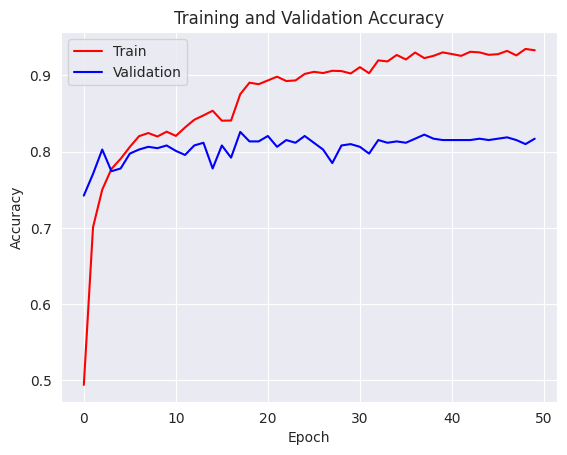

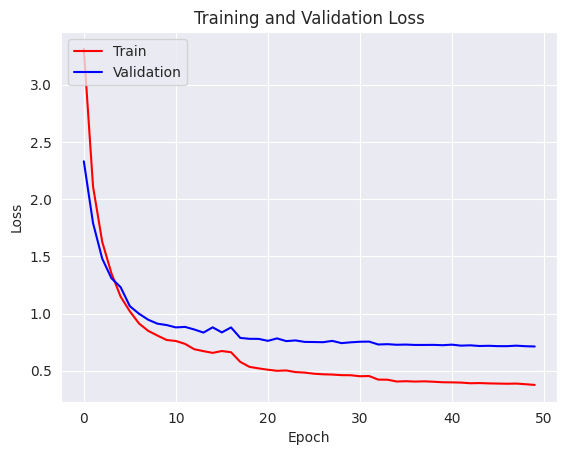

In [138]:
acc = history_food11.history['accuracy']
val_acc = history_food11.history['val_accuracy']
loss = history_food11.history['loss']
val_loss = history_food11.history['val_loss']

epochs = range(len(acc))

# Plot Akurasi
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Penyimpanan Model

## SavedModel

In [139]:
save_path = 'mymodel/'
tf.saved_model.save(model_food11, save_path)

## TF-Lite

In [140]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [141]:
import tensorflow as tf
import os

# Direktori penyimpanan model TFLite dan label
tflite_dir = "tflite"
if not os.path.exists(tflite_dir):
    os.makedirs(tflite_dir)

# Simpan model ke format SavedModel (opsional, sebagai langkah antara)
model_food11.export("food11_saved_model")

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("food11_saved_model")
tflite_model = converter.convert()

# Simpan model TFLite ke file
tflite_model_path = os.path.join(tflite_dir, "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"Model berhasil dikonversi dan disimpan sebagai {tflite_model_path}")

# Simpan label ke dalam label.txt
labels = train_generator.class_indices  # Dapatkan kelas dari generator
labels = {v: k for k, v in labels.items()}  # Inverse mapping untuk label -> class name

label_file_path = os.path.join(tflite_dir, "label.txt")
with open(label_file_path, "w") as f:
    for label in sorted(labels.keys()):
        f.write(f"{labels[label]}\n")

print(f"Label disimpan di {label_file_path}")

Saved artifact at 'food11_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_15')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  139247567921680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139247567923792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139247567925136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139247567924176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139247567920336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139247567924368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139247567925904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139247567927056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139247567926096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139247567921296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139247567

## TFJS

In [142]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import json

In [143]:
!pip install tensorflowjs

In [144]:
import tensorflowjs as tfjs
import os

# Direktori untuk menyimpan model TensorFlow.js
tfjs_dir = "tfjs_model"
if not os.path.exists(tfjs_dir):
    os.makedirs(tfjs_dir)

# Langsung simpan model Keras ke format TFJS
tfjs.converters.save_keras_model(model_food11, tfjs_dir)

print(f"Model berhasil dikonversi dan disimpan di {tfjs_dir}")

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi dan disimpan di tfjs_model


In [145]:
import shutil

shutil.make_archive("food11_saved_model", 'zip', "mymodel")
shutil.make_archive("tfjs_model", 'zip', "tfjs_model")
shutil.make_archive("tflite", 'zip', "tflite")

'/content/tflite.zip'

In [147]:
from google.colab import files

files.download("food11_saved_model.zip")
files.download("tfjs_model.zip")
files.download("tflite.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>